# Sphere test
Slicing a sphere for laser cutting 

In [10]:
%matplotlib inline

from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage
from skimage import measure

## Make sphere

In [2]:
def make_sphere(container_size, radius):

    idx = np.arange(0, container_size)
    center = np.median(idx)

    _x = idx
    _y = idx
    _z = idx
    x, y, z = np.meshgrid(_x, _y, _z, indexing='ij')
    
    sphere = (x-center)**2+(y-center)**2+(z-center)**2 <= radius**2
    sphere = sphere*1
    return sphere

In [3]:
big_sphere = make_sphere(71*5, 62/2*5)
little_sphere = make_sphere(71*5, 62/4*5)
composed_sphere = big_sphere-little_sphere

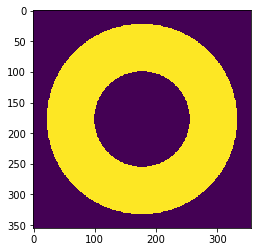

In [4]:
test_slice = composed_sphere[:,:,int(71*5/2)]
plt.imshow(test_slice)

Select slices for laser cutting:

In [5]:
slices_to_print = np.linspace(30,71*5-30,7).astype(int)
print(slices_to_print)

[ 30  79 128 177 226 275 325]


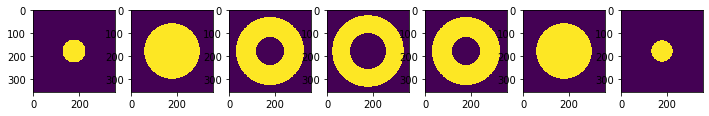

In [6]:
f, ax = plt.subplots(1, 7, figsize=(12,3))
for axi,i in zip(ax,slices_to_print):
    axi.imshow(composed_sphere[:,:,i])

In [7]:
print_slices = composed_sphere[:,:,slices_to_print]
print_shape = np.shape(print_slices)

print(print_shape)

(355, 355, 7)


## Image processing

Add rectangular base to slice:

In [8]:
def add_base(arr):
    w,h = np.shape(arr)

    # Fill inner hole
    arr_filled = ndimage.binary_fill_holes(arr)

    # Find horizontal bounds
    circle_horiz = np.sum(arr, axis=1)
    circle_horiz_coords = np.where(circle_horiz > 0)[0]
    circle_diameter = circle_horiz_coords[-1]-circle_horiz_coords[0]
    base_width = int(circle_diameter*.5)
    offset = int((w-base_width)/2)

    # Bounding box
    x0 = offset
    x1 = w-offset

    y0 = np.where(arr_filled[:,x0])[0][-1]
    y1 = h

    # Draw rectangle
    rect_arr = np.zeros((w,h))
    rect_arr[y0:y1, x0:x1] = 1

    # Slice + base
    base = (arr + rect_arr) > 0
    base = base*1
    
    return rect_arr, base

In [9]:
test_rect, test_base = add_base(test_slice)
plt.imshow(test_base)

NameError: name 'ndimage' is not defined

Detect contours in sphere:

In [ ]:
sphere_contours = measure.find_contours(test_slice, 0.8)

fig, ax = plt.subplots()
ax.imshow(test_slice, cmap=plt.cm.gray)

for n, contour in enumerate(sphere_contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

Detect contours in sphere + base:

In [ ]:
base_contours = measure.find_contours(test_base, 0.8)

fig, ax = plt.subplots()
ax.imshow(test_base, cmap=plt.cm.gray)

for n, contour in enumerate(base_contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

Find points in sphere contour that are not in base contour:

In [ ]:
arr2df = lambda df: pd.DataFrame({'y':df[:,0],'x':df[:,1]})
sphere_cat = np.concatenate(sphere_contours)
sphere_df = arr2df(sphere_cat)

sphere_df.head()

In [ ]:
base_cat = np.concatenate(base_contours)
base_df = arr2df(base_cat)

base_df.head()

In [ ]:
unique_df = pd.merge(sphere_df, base_df, on=['x','y'], how='left', indicator='belongs_to')
unique_df = unique_df[unique_df['belongs_to'] == 'left_only']
unique_df.drop('belongs_to', axis=1, inplace=True)
unique_df.head()

In [ ]:
unique_contour = unique_df.values

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_base, cmap=plt.cm.gray)

for n, contour in enumerate(base_contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='#ff0000')
    
ax.plot(unique_contour[:, 1], unique_contour[:, 0], linewidth=2, color='#0000ff')